
# **Give Me Some Credit**

# PROBLEM STATEMENT
Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

The goal of this activity is to build a model that borrowers can use to help make the best financial decisions.

In [0]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Reading the CSV files

In [0]:
train = pd.read_csv('/content/drive/My Drive/credit risk/cs-training.csv')
test = pd.read_csv('/content/drive/My Drive/credit risk/cs-test.csv')

In [0]:
print("Train: ",train.shape)
print("Test: ",test.shape)

Train:  (150000, 12)
Test:  (101503, 12)


In [0]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(3)

,Total,Percent
MonthlyIncome,29731,0.198207
NumberOfDependents,3924,0.026160
NumberOfTime60-89DaysPastDueNotWorse,0,0.000000


In [0]:
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(3)

,Total,Percent
SeriousDlqin2yrs,101503,1.000000
MonthlyIncome,20103,0.198053
NumberOfDependents,2626,0.025871


In [0]:

train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [0]:
train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Removing unnecessary columns

In [0]:
train = train.drop(columns = ['Unnamed: 0'])

In [0]:
test = test.drop(columns = ['Unnamed: 0'])

In [0]:
#define function to draw boxplots of train data
def draw_boxplots_tran(df_train, column1,column2,column3,column4):
    fig, axes = plt.subplots(2, 2, figsize=(10, 4))
    sns.boxplot(x=train[column1], ax=axes[0,0])
    axes[0,0].set_title("", fontsize=18)
    sns.boxplot(x=train[column2], color="green", ax= axes[0,1])
    axes[0,1].set_title("", fontsize=18)
    sns.boxplot(x=train[column3], color="green", ax= axes[1,0])
    sns.boxplot(x=train[column4], color="green", ax= axes[1,1])
    plt.show()
    return 

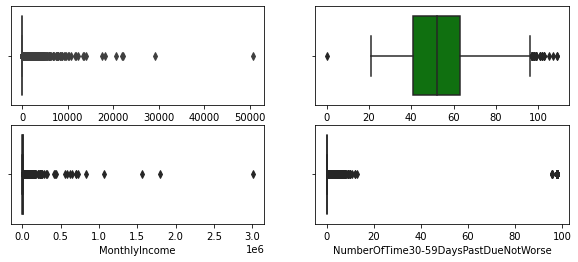

In [0]:
draw_boxplots_tran(train,'RevolvingUtilizationOfUnsecuredLines','age','MonthlyIncome','NumberOfTime30-59DaysPastDueNotWorse')

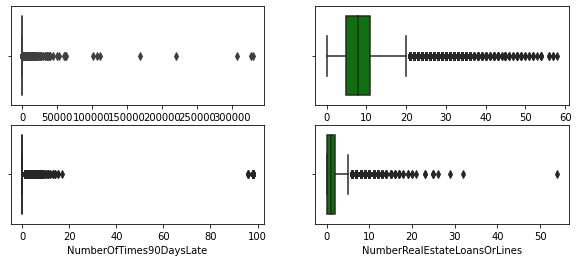

In [0]:
draw_boxplots_tran(train,'DebtRatio','NumberOfOpenCreditLinesAndLoans','NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines')

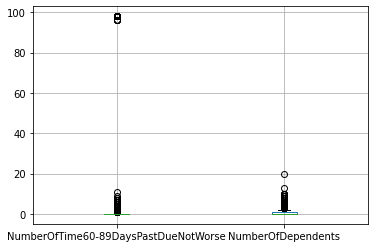

In [0]:
train.boxplot(['NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents'])
plt.show()

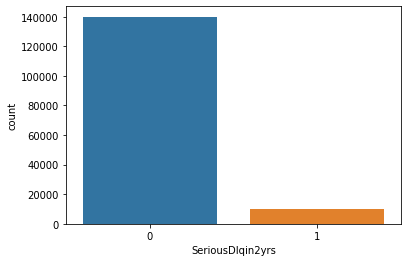

In [0]:
sns.countplot(x='SeriousDlqin2yrs',data=train)
plt.show()

In [0]:
train.SeriousDlqin2yrs.value_counts(normalize=True)

0    0.93316
1    0.06684
Name: SeriousDlqin2yrs, dtype: float64

Imputing the NA values

In [0]:
train['MonthlyIncome'].fillna(train['MonthlyIncome'].median(),inplace=True)
train['NumberOfDependents'].fillna(train['NumberOfDependents'].mode()[0],inplace=True)
test['MonthlyIncome'].fillna(test['MonthlyIncome'].median(),inplace=True)
test['NumberOfDependents'].fillna(test['NumberOfDependents'].mode()[0],inplace=True)

In [0]:
test.isnull().sum()

SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                                0
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                           0
dtype: int64

In [0]:
test = test.drop(columns = ['SeriousDlqin2yrs'])

Removing outliers with IQR and Z scores

In [0]:
q1 = np.percentile(train["RevolvingUtilizationOfUnsecuredLines"],25)
q3 = np.percentile(train["RevolvingUtilizationOfUnsecuredLines"],75)
iqr = q3-q1
upper = q3+3*iqr
lower = q1-3*iqr
lower, upper

(-1.5576689744999999, 2.146582664)

In [0]:
train_iqr = train[(train["RevolvingUtilizationOfUnsecuredLines"]<upper) & (train["RevolvingUtilizationOfUnsecuredLines"]>lower)]

In [0]:
from scipy import stats
zscore = np.abs(stats.zscore(train_iqr["DebtRatio"]))
print(zscore)

[0.17257784 0.17291193 0.17292996 ... 1.72529542 0.17297171 0.17284913]


In [0]:
train_iqr1 = train_iqr[(zscore < 3)]

In [0]:
train_iqr1.shape

(149006, 11)

In [0]:
train_iqr1.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149006.000000,149006.000000,149006.000000,149006.000000,149006.000000,1.490060e+05,149006.00000,149006.000000,149006.000000,149006.000000,149006.000000
mean,0.066648,0.320532,52.291076,0.421473,299.219578,6.422334e+03,8.43605,0.267016,1.007376,0.241413,0.738447
std,0.249413,0.356409,14.787380,4.206180,874.685548,1.292991e+04,5.13314,4.182746,1.108154,4.168859,1.107429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029708,41.000000,0.000000,0.174007,3.900000e+03,5.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.152838,52.000000,0.000000,0.364517,5.400000e+03,8.00000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.554525,63.000000,0.000000,0.843845,7.400000e+03,11.00000,0.000000,2.000000,0.000000,1.000000
max,1.000000,2.143095,109.000000,98.000000,6467.000000,3.008750e+06,58.00000,98.000000,54.000000,98.000000,20.000000


In [0]:
from scipy import stats
zscore1 = np.abs(stats.zscore(train_iqr1["NumberOfTime30-59DaysPastDueNotWorse"]))
print(zscore1)

[0.37528885 0.10020361 0.13754262 ... 0.10020361 0.10020361 0.10020361]


In [0]:
train_iqr1 = train_iqr1[(zscore1 < 3)]

In [0]:
train_iqr1.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,148737.000000,148737.000000,148737.000000,148737.000000,148737.000000,1.487370e+05,148737.000000,148737.000000,148737.000000,148737.000000,148737.000000
mean,0.065781,0.319303,52.323712,0.245063,299.750354,6.427011e+03,8.451293,0.090327,1.009197,0.064678,0.739191
std,0.247899,0.355557,14.770397,0.696673,875.386331,1.294070e+04,5.125237,0.483508,1.108326,0.329434,1.107784
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029598,41.000000,0.000000,0.174984,3.900000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.151936,52.000000,0.000000,0.365119,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.550710,63.000000,0.000000,0.845654,7.411000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,2.143095,109.000000,13.000000,6467.000000,3.008750e+06,58.000000,17.000000,54.000000,11.000000,20.000000


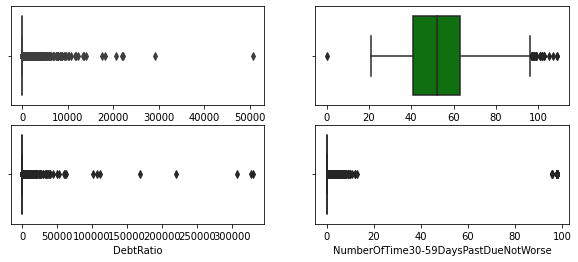

In [0]:
draw_boxplots_tran(train_iqr1,'RevolvingUtilizationOfUnsecuredLines','age','DebtRatio','NumberOfTime30-59DaysPastDueNotWorse')

In [0]:
feature_names = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio','MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']

In [0]:
y= train_iqr1["SeriousDlqin2yrs"]
X= train_iqr1.drop('SeriousDlqin2yrs',axis=1)

In [0]:
print(X.shape)
print(y.shape)

(148737, 10)
(148737,)


Standardization:

In [0]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X)

Train Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.20,random_state=121) 

Model Building

Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [0]:
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt') 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 100, 150],
           "max_depth" : [2,3,5,7,9],
           "min_samples_leaf" : [2, 4]}

In [0]:
clf_randomgrid = RandomizedSearchCV(rfc, param_distributions=param_grid, cv=5)

In [0]:
clf_randomgrid.fit(X=X_train, y=y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='sqrt',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
best_est = clf_randomgrid.best_estimator_

In [0]:
prob_rfc=best_est.predict_proba(X_test)
prob_rfc = prob_rfc[:,1]

In [0]:
prob_rfctrain=best_est.predict_proba(X_train)
prob_rfctrain = prob_rfctrain[:,1]

In [0]:
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import roc_auc_score

In [0]:
roc_auc_score(y_train, prob_rfctrain)

0.8676393295838645

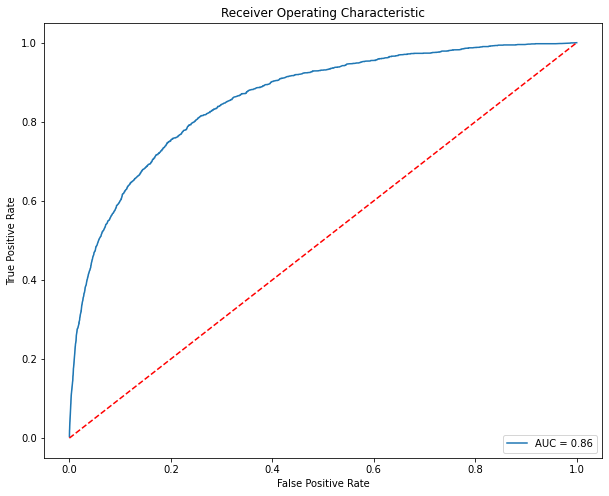

In [0]:
fpr,tpr,_ = roc_curve(y_test, prob_rfc)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
importances = best_est.feature_importances_
indices = np.argsort(importances)
print(indices)

[9 4 3 5 1 7 0 8 2 6]


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
features = X_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices], color='b')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [0]:
sub1 = best_est.predict_proba(test)[:,1]

In [0]:
submission = pd.read_csv("/content/drive/My Drive/credit risk/sampleEntry.csv")

In [0]:
submission["Probability"]=sub1
submission.head()

,Id,Probability
0,1,0.058912
1,2,0.094222
2,3,0.066433
3,4,0.167680
4,5,0.058912


In [0]:
submission.to_csv('submission1rfc.csv', index=False, header=True) #.865 scorecard

Model2: Logistic Regression

In [0]:
logr = LogisticRegression() 

In [0]:
logr.fit(X=X_train, y=y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
prob_log=logr.predict_proba(X_test)
prob_log = prob_log[:,1]

In [0]:
prob_logtrain=logr.predict_proba(X_train)
prob_logtrain = prob_logtrain[:,1]

In [0]:
roc_auc_score(y_train, prob_logtrain)

0.8511095190928145

In [0]:
roc_auc_score(y_test, prob_log)

0.8480729292585373

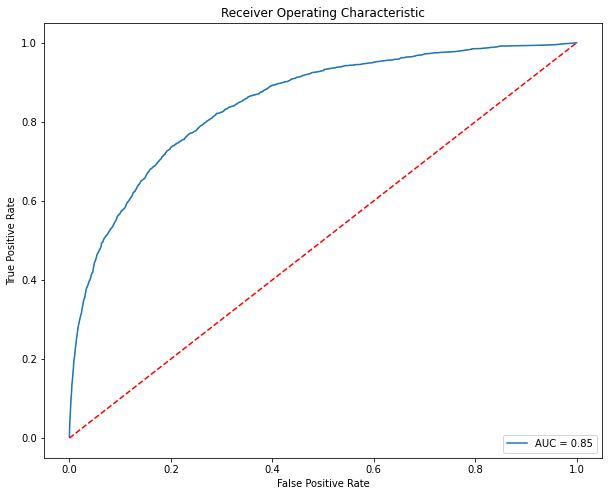

In [0]:
fpr,tpr,_ = roc_curve(y_test, prob_log)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Model3: KNNClassifier

In [0]:
from sklearn.neighbors import KNeighborsClassifier


In [0]:
neigh = KNeighborsClassifier(n_neighbors=3)

In [0]:
neigh.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [0]:
prob_knn=neigh.predict_proba(X_test)
prob_knn = prob_knn[:,1]

In [0]:
prob_knntrain = neigh.predict_proba(X_train)[:,1]

In [0]:
roc_auc_score(y_train, prob_knntrain)

0.9688016965580819

In [0]:
roc_auc_score(y_test, prob_knn)

0.6915999146189686

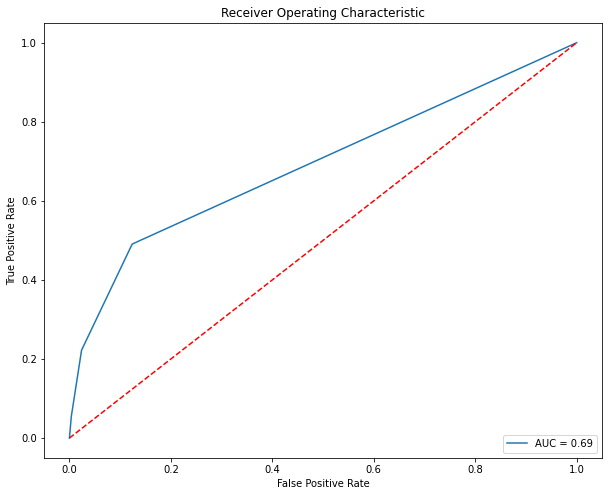

In [0]:
fpr,tpr,_ = roc_curve(y_test, prob_knn)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

KNNClassifier with GridSearchCV

In [0]:
model_KNN = KNeighborsClassifier()

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_grid = dict(n_neighbors=neighbors)

In [0]:
KNN_GridSearch = GridSearchCV(model_KNN,param_grid=param_grid,cv=10)

In [0]:
KNN_GridSearch.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
prob_knn1=KNN_GridSearch.predict_proba(X_test)
prob_knn1 = prob_knn1[:,1]
roc_auc_score(y_test, prob_knn1)

0.8117500429326521

In [0]:
prob_knntrain1=KNN_GridSearch.predict_proba(X_train)[:,1]
roc_auc_score(y_train, prob_knntrain1)

0.909445124569417

SVM

In [0]:
from sklearn.svm import SVC

In [0]:
svm1 = SVC(kernel='rbf',C=1.0,probability=True)

In [0]:
svm1.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
prob_svm=svm1.predict_proba(X_test)
prob_svm = prob_svm[:,1]
roc_auc_score(y_test, prob_svm)

0.6511155970507039

In [0]:
prob_svmtrain=svm1.predict_proba(X_train)[:,1]
roc_auc_score(y_train, prob_svmtrain)


0.7089074752671491

XGBoost

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [0]:
xgbc = XGBClassifier(n_jobs=-1) 
 
# Use a grid over parameters of interest
param_grid = {
                  'n_estimators' :[100,150,200,250,300],
                  "learning_rate" : [0.001,0.01,0.0001,0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3 ],
                  "colsample_bytree" : [ 0.3, 0.4, 0.5,0.7],
                  'max_depth': [3,4,6,8,9]
              }

In [0]:
xgb_randomgrid = RandomizedSearchCV(xgbc, param_distributions=param_grid, cv=5)

In [0]:
%%time
xgb_randomgrid.fit(X_train,y_train)

CPU times: user 15min 20s, sys: 2.1 s, total: 15min 22s
Wall time: 7min 50s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, s...
                                           verbosity=1),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'colsample_bytree':

In [0]:
best_est = xgb_randomgrid.best_estimator_

In [0]:
import pickle
Pkl_Filename = "Pickle_RL_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_est, file)

In [0]:
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.3,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
prob_xgbtrain = best_est.predict_proba(X_train)
prob_xgbtrain = prob_xgbtrain[:,1]
roc_auc_score(y_train,prob_xgbtrain)

0.8675952214200608

In [0]:
from sklearn.metrics import accuracy_score,classification_report, recall_score, precision_score,confusion_matrix

In [0]:
prob_xgb=best_est.predict_proba(X_test)
prob_xgb = prob_xgb[:,1]
roc_auc_score(y_test,prob_xgb)

0.859584914825716

In [0]:
scaler = StandardScaler()
test1 = scaler.fit_transform(test)

In [0]:
sub2 = best_est.predict_proba(test1)[:,1]

In [0]:
submission['Probability'] = sub2

In [0]:
submission.to_csv('submissionxgb.csv', index=False, header=True)

XGBoost performs better when compared to other models and hence it is saved.

STACKING with Randomforest, Logistic Regression, KNN and XGBoost

In [0]:
stack_train = pd.DataFrame([prob_rfctrain,prob_logtrain,prob_knntrain1,prob_xgbtrain])
stack_test = pd.DataFrame([prob_rfc,prob_log,prob_knn1,prob_xgb])

In [0]:
stack_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,118949,118950,118951,118952,118953,118954,118955,118956,118957,118958,118959,118960,118961,118962,118963,118964,118965,118966,118967,118968,118969,118970,118971,118972,118973,118974,118975,118976,118977,118978,118979,118980,118981,118982,118983,118984,118985,118986,118987,118988
0,0.015783,0.070560,0.037595,0.073769,0.027294,0.022568,0.015375,0.028241,0.618656,0.024362,0.070424,0.017366,0.090387,0.011247,0.016801,0.023075,0.019455,0.022299,0.024622,0.127811,0.014360,0.086919,0.087198,0.055266,0.020092,0.018590,0.009269,0.010778,0.024180,0.090024,0.084544,0.012936,0.047290,0.021115,0.015651,0.028068,0.010965,0.032980,0.011070,0.048463,...,0.141090,0.065402,0.010475,0.009998,0.010971,0.052832,0.009652,0.086914,0.337702,0.091510,0.015822,0.017776,0.082612,0.420134,0.014731,0.018877,0.055313,0.018946,0.076131,0.068141,0.014198,0.020576,0.011033,0.056311,0.009505,0.011378,0.019857,0.393251,0.009543,0.020283,0.024674,0.012010,0.014654,0.019211,0.079072,0.028122,0.074367,0.137253,0.015565,0.009801
1,0.015642,0.099364,0.060272,0.100993,0.038938,0.019759,0.013997,0.052183,0.573240,0.028881,0.067803,0.014874,0.093677,0.013790,0.017385,0.022905,0.019348,0.038391,0.045563,0.105853,0.016638,0.138012,0.146304,0.037820,0.024471,0.015340,0.008463,0.013107,0.025617,0.157791,0.133800,0.016133,0.031765,0.024169,0.020917,0.042891,0.012580,0.021361,0.009615,0.058006,...,0.065034,0.093252,0.012140,0.009111,0.014155,0.083147,0.009264,0.163510,0.224337,0.080126,0.014732,0.020304,0.037049,0.696340,0.015712,0.027293,0.026391,0.023679,0.084312,0.055261,0.014216,0.019130,0.014384,0.047659,0.011299,0.011256,0.016561,0.312273,0.011904,0.016587,0.027516,0.017123,0.021123,0.031465,0.072513,0.041579,0.046613,0.145719,0.017302,0.013795
2,0.000000,0.000000,0.000000,0.100000,0.050000,0.000000,0.000000,0.000000,0.600000,0.000000,0.050000,0.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.050000,0.050000,0.200000,0.000000,0.050000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.150000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,...,0.100000,0.050000,0.000000,0.000000,0.000000,0.100000,0.050000,0.150000,0.500000,0.050000,0.050000,0.050000,0.150000,0.700000,0.000000,0.050000,0.050000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.050000,0.200000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.150000,0.000000,0.100000,0.100000,0.000000,0.000000
3,0.012267,0.108401,0.047781,0.078781,0.024743,0.014790,0.013100,0.052871,0.699351,0.015978,0.049791,0.011044,0.084979,0.006914,0.007847,0.019766,0.011224,0.018549,0.028580,0.160195,0.010871,0.056641,0.045415,0.069013,0.008986,0.007522,0.006021,0.006231,0.012513,0.063984,0.086235,0.005722,0.022217,0.024723,0.012122,0.027344,0.003687,0.033344,0.003191,0.031454,...,0.098819,0.050479,0.007954,0.006170,0.010957,0.022066,0.004968,0.165015,0.471081,0.079229,0.007511,0.009626,0.085590,0.566114,0.010902,0.013671,0.029819,0.008744,0.069651,0.057320,0.017951,0.018714,0.009558,0.070166,0.006499,0.005873,0.015700,0.348450,0.004812,0.007432,0.020915,0.006294,0.011388,0.012760,0.065676,0.027959,0.066016,0.085991,0.010055,0.003428


In [0]:
stack_train = stack_train.T  # T - for transpose
stack_test = stack_test.T

In [0]:
print(stack_train.head())
print(stack_test.head())

          0         1     2         3
0  0.015783  0.015642  0.00  0.012267
1  0.070560  0.099364  0.00  0.108401
2  0.037595  0.060272  0.00  0.047781
3  0.073769  0.100993  0.10  0.078781
4  0.027294  0.038938  0.05  0.024743
          0         1     2         3
0  0.010771  0.011134  0.00  0.012756
1  0.040887  0.042644  0.00  0.057973
2  0.214399  0.209653  0.25  0.237930
3  0.009573  0.009387  0.00  0.004689
4  0.009269  0.007836  0.00  0.004785


In [0]:
stack_train.columns = ['prob_rfctrain','prob_logtrain','prob_knntrain1','prob_xgbtrain']
stack_test.columns = ['prob_rfc','prob_log','prob_knn1','prob_xgb']

In [0]:
print(stack_train.shape)
print(stack_test.shape)

(118989, 4)
(29748, 4)


In [0]:
dtc = LogisticRegression()

dtc.fit(stack_train,y_train)

stacked_pred_train = dtc.predict(stack_train)
stacked_pred_test = dtc.predict(stack_test)

In [0]:
roc_auc_score(y_train,stacked_pred_train)

0.6463543245001409

In [0]:
roc_auc_score(y_test,stacked_pred_test)

0.6125906102471393

Stacking doesn't improve the score when compared to the previous models.

Using SMOTE for Imbalanced Data

In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
smote = SMOTE(random_state=0)

os_data_X,os_data_y=smote.fit_sample(X_train,y_train)

#os_data_X = pd.DataFrame(data=os_data_X)
#os_data_y= pd.DataFrame(data=os_data_y,columns=['SeriousDlqin2yrs'])


In [0]:
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['SeriousDlqin2yrs']==0]))
print("Number of subscription",len(os_data_y[os_data_y['SeriousDlqin2yrs']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['SeriousDlqin2yrs']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['SeriousDlqin2yrs']==1])/len(os_data_X))

In [0]:
xgbsmote = XGBClassifier(n_jobs=-1) 
 
# Use a grid over parameters of interest
param_grid = {
                  'n_estimators' :[100,150,200,250,300],
                  "learning_rate" : [0.001,0.01,0.0001,0.05, 0.10 ],
                  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3 ],
                  "colsample_bytree" : [0.5,0.7],
                  'max_depth': [3,4,6,8]
              }

In [0]:
xgbsmote_randomgrid = RandomizedSearchCV(xgbsmote, param_distributions=param_grid, cv=5)

In [0]:
%%time
xgbsmote_randomgrid.fit(os_data_X,os_data_y)

CPU times: user 34min 27s, sys: 3.73 s, total: 34min 31s
Wall time: 17min 35s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, s...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_i

In [0]:
best_est = xgbsmote_randomgrid.best_estimator_

In [0]:
train_pred1 = best_est.predict_proba(os_data_X)
train_pred1 = train_pred1[:,1]

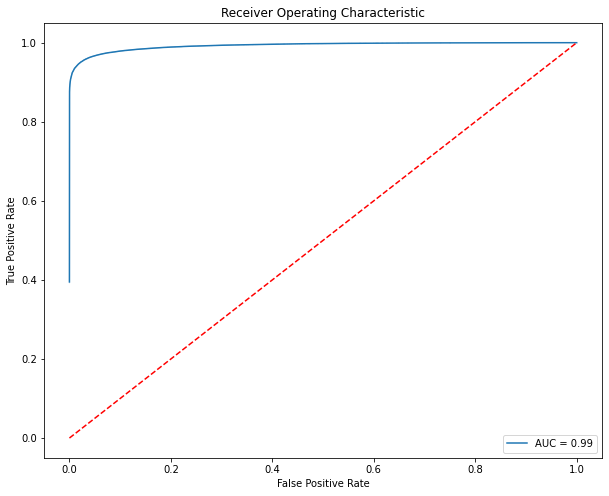

In [0]:
fpr,tpr,_ = roc_curve(os_data_y, train_pred1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
prob5=best_est.predict_proba(X_test)
prob5 = prob5[:,1]

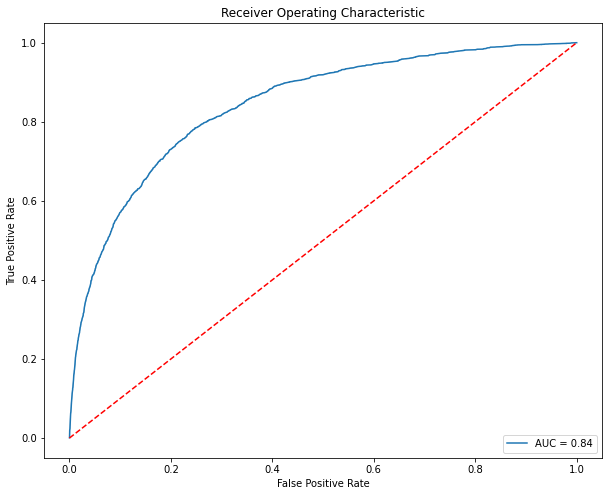

In [0]:
fpr,tpr,_ = roc_curve(y_test, prob5)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
sns.lineplot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
pred = best_est.predict_proba(test1)[:,1]

In [0]:
submission["Probability"]=pred

In [0]:
submission.to_csv("smoterfc.csv", index=False, header=True)